## Trained on LSTM, and transformers | Will try on other models

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

cafa_6_protein_function_prediction_path = kagglehub.competition_download('cafa-6-protein-function-prediction')

print('Data source import complete.')


Data source import complete.


In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cafa_6_protein_function_prediction_path = kagglehub.competition_download('cafa-6-protein-function-prediction')

print('Data source import complete.')

Data source import complete.


In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cafa_6_protein_function_prediction_path = kagglehub.competition_download('cafa-6-protein-function-prediction')

print('Data source import complete.')

Data source import complete.


In [8]:
from torch.cuda.amp import GradScaler, autocast

In [9]:

import numpy as np
import pandas as pd
import os
! pip install Bio goatools
from Bio import SeqIO
from goatools import obo_parser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 131.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.4 MB/s eta 0:00:00


In [10]:
os.listdir(cafa_6_protein_function_prediction_path)

['Train', 'IA.tsv', 'Test', 'sample_submission.tsv']

In [11]:
files = []
for dirname, _, filenames in os.walk(cafa_6_protein_function_prediction_path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

In [12]:
files

['/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/IA.tsv',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/sample_submission.tsv',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_terms.tsv',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/go-basic.obo',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_sequences.fasta',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Test/testsuperset.fasta',
 '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv']

In [13]:
file_names = [str(files[x]).split("/")[-1] for x in range(len(files))]
filedict = dict(zip(file_names,files))
filedict

{'IA.tsv': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/IA.tsv',
 'sample_submission.tsv': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/sample_submission.tsv',
 'train_terms.tsv': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_terms.tsv',
 'go-basic.obo': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/go-basic.obo',
 'train_taxonomy.tsv': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv',
 'train_sequences.fasta': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/train_sequences.fasta',
 'testsuperset.fasta': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Test/testsuperset.fasta',
 'testsuperset-taxon-list.tsv': '/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv'}

In [14]:
train_terms = pd.read_csv(filedict['train_terms.tsv'],sep='\t')
train_terms['term'] = [x[1] for x in train_terms['term'].str.split(":")] # removed "GO :" from
nunique_go = len(train_terms['term'].unique())
train_terms =train_terms.rename(columns={'EntryID':'UniprotID'})

In [15]:
train_terms

,UniprotID,term,aspect
0,Q5W0B1,0000785,C
1,Q5W0B1,0004842,F
2,Q5W0B1,0051865,P
3,Q5W0B1,0006275,P
4,Q5W0B1,0006513,P
...,...,...,...
537022,Q06667,0070481,P
537023,B1NF19,0033075,P
537024,B1NF19,0047052,F
537025,B1NF19,0047056,F


In [16]:
seqs_dict ={}

with open(filedict['train_sequences.fasta'], 'r') as f:
    x =  f.readlines()
    # Modify headers to keep only Uniprot ID
    for line in x:
        if line.startswith('>'):
            # Extract Uniprot ID (assuming format sp|UniprotID|...)
            uniprot_id = line.split('|')[1]
        else:
            fasta_seq= line.replace("\n","")
            seqs_dict[uniprot_id] = fasta_seq

trian_seq_Df = pd.DataFrame(seqs_dict.items(), columns=['UniprotID', 'Sequence'])

In [17]:
trian_seq_Df

,UniprotID,Sequence
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR
1,A0JNW5,KMALAEAHLEKDALLHHIKKMTVE
2,A0JP26,DETKHQNQLRENKILEEIESVKEKLLKAIQLNEEALTKTSI
3,A0PK11,VEEQYEESFWICVASASAHAANLVVVAISQIPLPEIKTKIEEATVT...
4,A1A4S6,NYVKLL
...,...,...
82399,Q9UTM1,IIYLKKTMRVTPSEEKIHEMINQKRETKKRKRKQKKKNDDDYGVFE...
82400,Q9Y7I1,DRLNLKEPVDLEGPKDEQ
82401,Q9Y7P7,LGLLVFLHSLIVARFFVASKSRSCIVRSLLFWINLDSADSRISVLF...
82402,Q9Y7Q3,EMTRIYLSIRKNFFQICLKTHSPQLPLGR


In [18]:
## taxonomy file

train_tax = pd.read_csv(filedict['train_taxonomy.tsv'], sep='\t',header=None)
train_tax.columns= ['UniprotID','TaxonomyID']

total taxas:67335


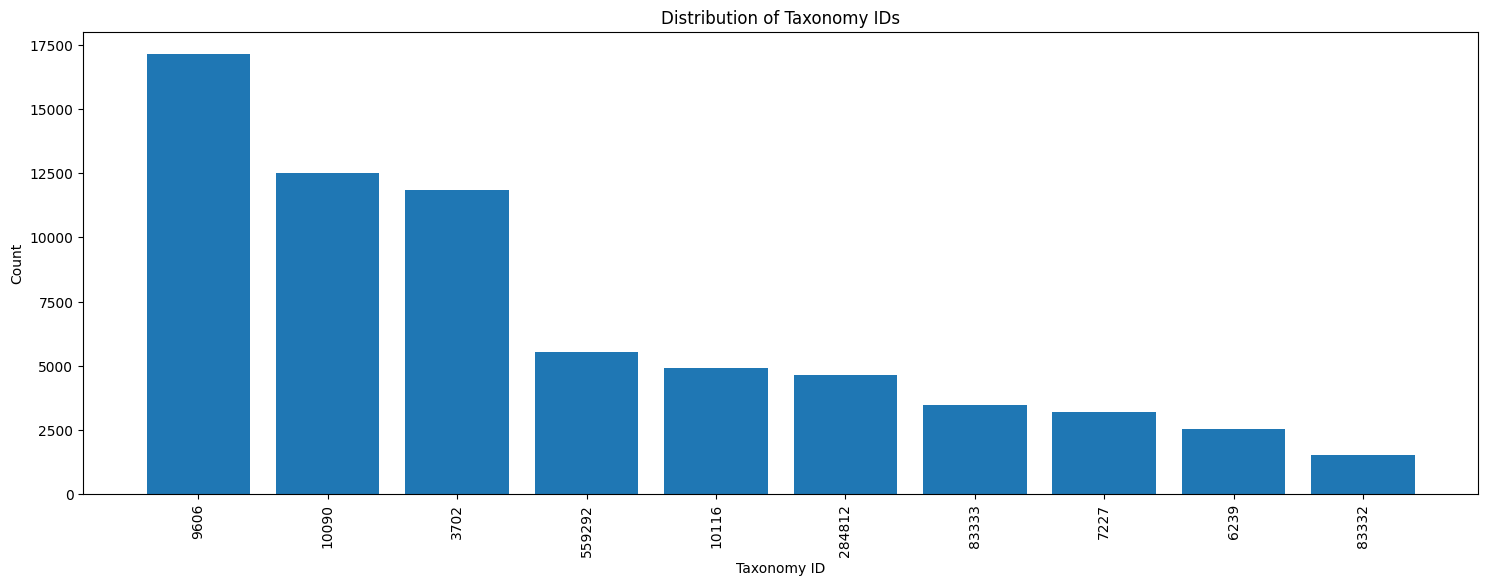

In [19]:
import matplotlib.pyplot as plt

# plotting top 10
taxonomy_counts = train_tax['TaxonomyID'].value_counts()[:10]
total_taxas = sum(taxonomy_counts)
print(f"total taxas:{total_taxas}")

plt.figure(figsize=(18, 6))
plt.bar(taxonomy_counts.index.astype(str), taxonomy_counts.values)
plt.xlabel('Taxonomy ID')
plt.ylabel('Count')
plt.title('Distribution of Taxonomy IDs')
plt.xticks(rotation=90)
plt.show()

In [20]:
train_terms

,UniprotID,term,aspect
0,Q5W0B1,0000785,C
1,Q5W0B1,0004842,F
2,Q5W0B1,0051865,P
3,Q5W0B1,0006275,P
4,Q5W0B1,0006513,P
...,...,...,...
537022,Q06667,0070481,P
537023,B1NF19,0033075,P
537024,B1NF19,0047052,F
537025,B1NF19,0047056,F


In [21]:
main_df = pd.merge(train_tax, trian_seq_Df, on='UniprotID')
main_df = pd.merge(main_df, train_terms, on='UniprotID')

main_df.shape

(537027, 5)

In [22]:
## read GO obo file
go = obo_parser.GODag(filedict["go-basic.obo"])
# Display a few GO terms
for i, (go_id, term) in enumerate(list(go.items())[:5]):
    print(f"{go_id}: {term.name}")

/root/.cache/kagglehub/competitions/cafa-6-protein-function-prediction/Train/go-basic.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms
GO:0000001: mitochondrion inheritance
GO:0000002: mitochondrial genome maintenance
GO:0000006: high-affinity zinc transmembrane transporter activity
GO:0000007: low-affinity zinc ion transmembrane transporter activity
GO:0000009: alpha-1,6-mannosyltransferase activity


In [23]:
## Base model: Prepare a model takes sequence as input and predict GO terms as output

'''Issues:
1. One sequence is associated with more than 1 GO term (inclusive of CC, MF, and BP).
2. Work for single GO subtype
3. Initially predict top most only

'''

'Issues:\n1. One sequence is associated with more than 1 GO term (inclusive of CC, MF, and BP).\n2. Work for single GO subtype\n3. Initially predict top most only\n\n'

In [24]:
## Filter only CC subtype
cc_main_df = main_df[main_df['aspect']=='C']
cc_main_df

,UniprotID,TaxonomyID,Sequence,term,aspect
2,A0A0C5B5G6,9606,MRWQEMGYIFYPRKLR,0005615,C
3,A0A0C5B5G6,9606,MRWQEMGYIFYPRKLR,0005634,C
4,A0A0C5B5G6,9606,MRWQEMGYIFYPRKLR,0005739,C
16,A0JNW5,9606,KMALAEAHLEKDALLHHIKKMTVE,0005769,C
19,A0JNW5,9606,KMALAEAHLEKDALLHHIKKMTVE,0005829,C
...,...,...,...,...,...
537022,Q9Y7Q3,284812,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005634,C
537023,Q9Y7Q3,284812,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005739,C
537024,Q9Y7Q3,284812,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005829,C
537025,Q9Y816,284812,PSYPFSEITEVSRGGLHFVKLN,0005737,C


In [25]:
train_cc_df =cc_main_df[['Sequence', 'term']]
train_cc_df

,Sequence,term
2,MRWQEMGYIFYPRKLR,0005615
3,MRWQEMGYIFYPRKLR,0005634
4,MRWQEMGYIFYPRKLR,0005739
16,KMALAEAHLEKDALLHHIKKMTVE,0005769
19,KMALAEAHLEKDALLHHIKKMTVE,0005829
...,...,...
537022,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005634
537023,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005739
537024,EMTRIYLSIRKNFFQICLKTHSPQLPLGR,0005829
537025,PSYPFSEITEVSRGGLHFVKLN,0005737


In [26]:
# Single sequence associated with >1 GO term
## using probability we can filter top 3 GO terms

In [27]:
# Prepare tokens


label2enc = { val:indx for indx, val in enumerate(train_cc_df['term'].unique())}
enc2label = { indx:val for indx, val in enumerate(train_cc_df['term'].unique())}
lab_df = pd.DataFrame.from_dict(label2enc,orient='index').reset_index(drop=False)
train_cc_df['label'] = train_cc_df['term'].map(label2enc)

print(train_cc_df.head())

                    Sequence     term  label
2           MRWQEMGYIFYPRKLR  0005615      0
3           MRWQEMGYIFYPRKLR  0005634      1
4           MRWQEMGYIFYPRKLR  0005739      2
16  KMALAEAHLEKDALLHHIKKMTVE  0005769      3
19  KMALAEAHLEKDALLHHIKKMTVE  0005829      4


/tmp/ipython-input-800628069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cc_df['label'] = train_cc_df['term'].map(label2enc)


In [28]:

## Trunc or Pad sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

seq_len = np.array(train_cc_df.iloc[:,0].apply(len))
ave_seq = np.ceil(np.mean(seq_len))
print('\nAverage seq length:',ave_seq)


print('\nThis length will be useful for truncating and padding the sequencing for constant embeddings')


## Prepare vocab
## Creating vocab of aa
aa_vocab = [list(seq) for seq in train_cc_df['Sequence'][:100].astype(str)]
aa = sorted(list(set([aa for seq in aa_vocab for aa in seq])))
print("Total amino acids:", len(aa))

aa_df = pd.DataFrame(aa)

enc = LabelEncoder()
aa_df = pd.DataFrame(aa, columns=["AA"])

## padding and truncating code
aa_df.loc[len(aa_df)] = ['<PAD>']
aa_df.loc[len(aa_df)] = ['<START>']
aa_df.loc[len(aa_df)] = ['<END>']
aa_df.loc[len(aa_df)] = ['<UNK>']

aa_enc = enc.fit_transform(aa_df)



aa2vec_dict = {aa_df.iloc[i,0]:aa_enc[i] for i in range(len(aa_df))}
# aa_df_enc = pd.DataFrame({
#     'AA': list(aa_vec_dict.keys()),
#     'encoding': list(aa_vec_dict.values())
# })


Average seq length: 31.0

This length will be useful for truncating and padding the sequencing for constant embeddings
Total amino acids: 20


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# Prepare tokens
'''
Read each sentence
Read each amino acid
fetch encoding and add into the list in the corresponding column
use each cells as a sample encoding
'''

## set len of the seq
seq_len_min = 400
print(f"Set Sequence length={seq_len_min}")

# enc_dict_seq = df_main.iloc[:n_seqs,[0,2]].copy()
def tokenization(sequence, aa2idx, seq_len_min):
    token = ["<START>"] + list(sequence) + ["<END>"]
    if len(token) > seq_len_min:
        token = token[:seq_len_min-1]
        token.append("<END>")
    else:
        token += ["<PAD>"] * (seq_len_min - len(token))

    encoded = [aa2idx.get(a, aa2idx["<UNK>"]) for a in token]
    return encoded

Set Sequence length=400


In [30]:

# dataset = pd.DataFrame()
np.random.seed(42)
n_seqs = np.random.randint(0,len(train_cc_df), size=int(len(train_cc_df)*0.3)) ##Randomly selecting samples
sequences = train_cc_df.iloc[n_seqs,[0,2]]
sequences

,Sequence,label
446847,EEGVAQMSVGQRAKLTISPDYAYGATGHPGIIPPHATLVFDVELLKLE,2408
516393,TFVVLFFYKRNEKKHALGNGIILYDSNKGEELPEFVKKNMEERDGY...,129
476029,NYLHRIGRSGRFGRKGVAINFVTLDDQRMLFDIQKFYNVVVEELPS...,18
377210,AEAKRMKVAKNPQNINPSSSQNSQNFATYKEGYNVYGIESVKI,632
440120,LADRRAGVSSL,18
...,...,...
311961,SGRSKGFGFVTYDSSQEVQNAIKSLDGADLDGRQIRVSEAEARPPRRQY,7
118918,CR,240
458341,RTRQASITTELIEIISGASALEAAK,1
353708,GEPRSQLHQLPKNPLSELPVVKCKRVALSLEDDGLP,247


In [31]:
## Faster - Vectorized of token

sequences_list = sequences.iloc[:, 0].tolist()
y = sequences.iloc[:, 1].values  # Direct numpy array

# Vectorized tokenization
X = [tokenization(seq, aa2vec_dict, seq_len_min) for seq in sequences_list]
X = np.array(X)

In [32]:

## preparing dataset

# Split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.33)

In [33]:
import torch
from torch.utils.data import TensorDataset
# Convert to tensors

print('\nPreparing Tensor dataset...')
X_tr_ten = torch.tensor(X_train, dtype=torch.long)
y_tr_ten = torch.tensor(y_train, dtype=torch.long)

X_te_ten = torch.tensor(X_test, dtype=torch.long)
y_te_ten = torch.tensor(y_test, dtype=torch.long)


train_ten = TensorDataset(X_tr_ten,y_tr_ten)
test_ten = TensorDataset(X_te_ten,y_te_ten)

from torch.utils.data import DataLoader

train_data = DataLoader(train_ten, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_data = DataLoader(test_ten, batch_size=64, shuffle=False,num_workers=2, pin_memory=True)


Preparing Tensor dataset...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [34]:
## Model LSTM
from torch import nn


vocab_size=len(aa2vec_dict)


device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

class LSTM_model(nn.Module):
    def __init__(self,vocab_size,n_class,emb_dim, hid_dim,n_layer):
        super(LSTM_model,self).__init__()

        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layer,
            dropout=0.3,
            bidirectional=True,
            batch_first=True
        )

        self.layer_norm = nn.LayerNorm(hid_dim * 2)
        self.dropouts = nn.Dropout(0.3 )
        self.fc = nn.Linear(hid_dim*2, n_class)

    def forward(self,x):
        embedded= self.embeddings(x)

        out, (h_n, c_n) = self.lstm(embedded)

        h_for = h_n[-2,:,:]
        h_back = h_n[-1,:,:]

        h_cat = torch.cat((h_for, h_back), dim=1)
        h_cat = self.layer_norm(h_cat)
        h_cat = self.dropouts(h_cat)
        logits = self.fc(h_cat)
        return logits

Using cuda device


In [35]:
# Model transformers
import math

class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    """Transformer model for protein sequence classification"""
    def __init__(self, vocab_size, n_class, d_model=128, nhead=8, num_layers=4,
                 dim_feedforward=512, dropout=0.1, max_len=5000):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important: batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, n_class)

        self._init_weights()

    def _init_weights(self):
        """Initialize weights"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len)

        # Embedding
        x = self.embedding(x) * math.sqrt(self.d_model)  # Scale embeddings
        x = self.pos_encoder(x)

        # Create padding mask if not provided
        if mask is None:
            # Assuming PAD token is 0
            mask = (x.sum(dim=-1) == 0)  # Shape: (batch_size, seq_len)

        # Transformer encoding
        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        # Global average pooling (better than just taking first token)
        if mask is not None:
            # Mask out padding tokens before averaging
            mask_expanded = mask.unsqueeze(-1).expand(x.size())
            sum_embeddings = torch.sum(x * (~mask_expanded), dim=1)
            sum_mask = torch.clamp((~mask).sum(dim=1, keepdim=True), min=1e-9)
            x = sum_embeddings / sum_mask
        else:
            x = x.mean(dim=1)  # Simple average pooling

        # Classification
        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.fc(x)

        return logits


class LightweightTransformerModel(nn.Module):
    """Lightweight transformer for faster training"""
    def __init__(self, vocab_size, n_class, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=256, dropout=0.1, max_len=5000):
        super(LightweightTransformerModel, self).__init__()

        self.d_model = d_model

        # Embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)

        # Lightweight transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Pre-norm for better training
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, n_class)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # Embedding with scaling
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)

        # Transformer encoding
        x = self.transformer_encoder(x)

        # Use CLS token approach (first token) for speed
        x = x[:, 0, :]  # Take first token

        # Classification
        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.fc(x)

        return logits

In [36]:

def training_loop(dataloader, model, loss_func, optimizer, scaler=None):
    model.train()
    total_loss = 0
    correct = 0

    for X_data, Y_data in dataloader:
        X_data, Y_data = X_data.to(device), Y_data.to(device)

        optimizer.zero_grad()

        # Mixed precision training with compatibility
        if scaler is not None and device == 'cuda':
            try:
                # Try new API
                with torch.amp.autocast('cuda'):
                    outputs = model(X_data)
                    loss = loss_func(outputs, Y_data)
            except (AttributeError, TypeError):
                # Fall back to old API
                with torch.cuda.amp.autocast():
                    outputs = model(X_data)
                    loss = loss_func(outputs, Y_data)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training without mixed precision
            outputs = model(X_data)
            loss = loss_func(outputs, Y_data)
            loss.backward()
            optimizer.step()

        _, predicted = outputs.max(1)
        correct += predicted.eq(Y_data).sum().item()
        total_loss += loss.item()

    accuracy = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy


def eval_loop(dataloader, model, loss_func):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for X_data, Y_data in dataloader:
            X_data, Y_data = X_data.to(device), Y_data.to(device)

            # Mixed precision for evaluation with compatibility
            if device == 'cuda':
                try:
                    with torch.amp.autocast('cuda'):
                        outputs = model(X_data)
                        loss = loss_func(outputs, Y_data)
                except (AttributeError, TypeError):
                    with torch.cuda.amp.autocast():
                        outputs = model(X_data)
                        loss = loss_func(outputs, Y_data)
            else:
                outputs = model(X_data)
                loss = loss_func(outputs, Y_data)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(Y_data).sum().item()

    accuracy = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

In [40]:
epoch=100


unique_labels = sorted(set(y))
n_class = len(train_cc_df['term'].unique())

print(f"Number of classes in sample: {n_class}")
# Standard Transformer
model_standard = TransformerModel(
    vocab_size=vocab_size,
    n_class=n_class,
    d_model=128,
    nhead=8,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1
)

model_light = LightweightTransformerModel(
    vocab_size=vocab_size,
    n_class=n_class,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1
)

Number of classes in sample: 2651


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [42]:

# print(f"Label range: {min(y)} to {max(y)}")


# print("Model n_class:", len(set(y)))


model = LSTM_model(vocab_size=vocab_size,n_class=n_class,emb_dim=32, hid_dim=64,n_layer=2).to(device)
# model= model_light
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## Issue in Kaggle ; No issue in GColab
try:
    from torch.amp import GradScaler
    scaler = GradScaler('cuda') if device == 'cuda' else None
except (ImportError, TypeError):
    # Fall back to old API (Kaggle's PyTorch version)
    try:
        from torch.cuda.amp import GradScaler
        scaler = GradScaler() if device == 'cuda' else None
    except ImportError:
        # No mixed precision support
        scaler = None

train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []

print(f"\nTraining for {epoch} epochs...")
best_test_acc = 0

for ep in range(epoch):
    train_loss, train_acc = training_loop(train_data, model, loss_func, optimizer, scaler)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    test_loss, test_acc = eval_loop(test_data, model, loss_func)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

    # Update learning rate
    scheduler.step(test_loss)

    # # Save best model
    # if test_acc > best_test_acc:
    #     best_test_acc = test_acc
    #     torch.save(model.state_dict(), 'best_model.pth')

    if ep%5 ==0:
      print(f"Epoch {ep + 1}/{epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
            f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}% | LR = {optimizer.param_groups[0]['lr']:.6f}")

print(f"\nBest Test Accuracy: {best_test_acc:.2f}%")


Training for 100 epochs...
Epoch 1/100: Train Loss = 5.7879, Train Acc = 7.98% | Test Loss = 5.6119, Test Acc = 8.76% | LR = 0.001000
Epoch 6/100: Train Loss = 5.4878, Train Acc = 9.47% | Test Loss = 5.5521, Test Acc = 9.90% | LR = 0.001000
Epoch 11/100: Train Loss = 5.2741, Train Acc = 10.36% | Test Loss = 5.5534, Test Acc = 9.96% | LR = 0.001000
Epoch 16/100: Train Loss = 5.0230, Train Acc = 11.65% | Test Loss = 5.5759, Test Acc = 9.77% | LR = 0.000250
Epoch 21/100: Train Loss = 4.9378, Train Acc = 12.37% | Test Loss = 5.5865, Test Acc = 9.87% | LR = 0.000063
Epoch 26/100: Train Loss = 4.9083, Train Acc = 12.92% | Test Loss = 5.5897, Test Acc = 9.82% | LR = 0.000031
Epoch 31/100: Train Loss = 4.8908, Train Acc = 13.01% | Test Loss = 5.5912, Test Acc = 9.85% | LR = 0.000008
Epoch 36/100: Train Loss = 4.8930, Train Acc = 12.81% | Test Loss = 5.5917, Test Acc = 9.86% | LR = 0.000002
Epoch 41/100: Train Loss = 4.8947, Train Acc = 12.72% | Test Loss = 5.5920, Test Acc = 9.85% | LR = 0.00

Training with Light transformer

Training for 100 epochs...
Epoch 1/100: Train Loss = 5.7656, Train Acc = 7.97% | Test Loss = 5.6073, Test Acc = 8.32% | LR = 0.001000
Epoch 6/100: Train Loss = 5.5782, Train Acc = 8.52% | Test Loss = 5.5875, Test Acc = 8.80% | LR = 0.001000
Epoch 11/100: Train Loss = 5.4828, Train Acc = 9.16% | Test Loss = 5.5872, Test Acc = 8.96% | LR = 0.000500
Epoch 16/100: Train Loss = 5.3547, Train Acc = 9.86% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000250
Epoch 21/100: Train Loss = 5.3107, Train Acc = 9.90% | Test Loss = 5.5869, Test Acc = 9.33% | LR = 0.000063
Epoch 26/100: Train Loss = 5.2972, Train Acc = 9.96% | Test Loss = 5.5844, Test Acc = 9.33% | LR = 0.000031
Epoch 31/100: Train Loss = 5.2884, Train Acc = 9.90% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000008
Epoch 36/100: Train Loss = 5.2887, Train Acc = 10.06% | Test Loss = 5.5862, Test Acc = 9.35% | LR = 0.000004
Epoch 41/100: Train Loss = 5.2888, Train Acc = 10.03% | Test Loss = 5.5863, Test Acc = 9.34% | LR = 0.000001
Epoch 46/100: Train Loss = 5.2841, Train Acc = 9.93% | Test Loss = 5.5862, Test Acc = 9.33% | LR = 0.000000
Epoch 51/100: Train Loss = 5.2838, Train Acc = 9.94% | Test Loss = 5.5863, Test Acc = 9.32% | LR = 0.000000
Epoch 56/100: Train Loss = 5.2873, Train Acc = 9.87% | Test Loss = 5.5862, Test Acc = 9.31% | LR = 0.000000
Epoch 61/100: Train Loss = 5.2854, Train Acc = 10.14% | Test Loss = 5.5862, Test Acc = 9.31% | LR = 0.000000
Epoch 66/100: Train Loss = 5.2862, Train Acc = 10.06% | Test Loss = 5.5862, Test Acc = 9.33% | LR = 0.000000

In [ ]:

# print(f"Label range: {min(y)} to {max(y)}")


# print("Model n_class:", len(set(y)))


#model = LSTM_model(vocab_size=vocab_size,n_class=n_class,emb_dim=32, hid_dim=64,n_layer=2).to(device)
model= model_light
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## Issue in Kaggle ; No issue in GColab
try:
    from torch.amp import GradScaler
    scaler = GradScaler('cuda') if device == 'cuda' else None
except (ImportError, TypeError):
    # Fall back to old API (Kaggle's PyTorch version)
    try:
        from torch.cuda.amp import GradScaler
        scaler = GradScaler() if device == 'cuda' else None
    except ImportError:
        # No mixed precision support
        scaler = None

train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []

print(f"\nTraining for {epoch} epochs...")
best_test_acc = 0

for ep in range(epoch):
    train_loss, train_acc = training_loop(train_data, model, loss_func, optimizer, scaler)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    test_loss, test_acc = eval_loop(test_data, model, loss_func)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

    # Update learning rate
    scheduler.step(test_loss)

    # # Save best model
    # if test_acc > best_test_acc:
    #     best_test_acc = test_acc
    #     torch.save(model.state_dict(), 'best_model.pth')

    if ep%5 ==0:
      print(f"Epoch {ep + 1}/{epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
            f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}% | LR = {optimizer.param_groups[0]['lr']:.6f}")

print(f"\nBest Test Accuracy: {best_test_acc:.2f}%")


Training for 100 epochs...
Epoch 1/100: Train Loss = 5.7656, Train Acc = 7.97% | Test Loss = 5.6073, Test Acc = 8.32% | LR = 0.001000
Epoch 6/100: Train Loss = 5.5782, Train Acc = 8.52% | Test Loss = 5.5875, Test Acc = 8.80% | LR = 0.001000
Epoch 11/100: Train Loss = 5.4828, Train Acc = 9.16% | Test Loss = 5.5872, Test Acc = 8.96% | LR = 0.000500
Epoch 16/100: Train Loss = 5.3547, Train Acc = 9.86% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000250
Epoch 21/100: Train Loss = 5.3107, Train Acc = 9.90% | Test Loss = 5.5869, Test Acc = 9.33% | LR = 0.000063
Epoch 26/100: Train Loss = 5.2972, Train Acc = 9.96% | Test Loss = 5.5844, Test Acc = 9.33% | LR = 0.000031
Epoch 31/100: Train Loss = 5.2884, Train Acc = 9.90% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000008
Epoch 36/100: Train Loss = 5.2887, Train Acc = 10.06% | Test Loss = 5.5862, Test Acc = 9.35% | LR = 0.000004
Epoch 41/100: Train Loss = 5.2888, Train Acc = 10.03% | Test Loss = 5.5863, Test Acc = 9.34% | LR = 0.000001


In [ ]:

# print(f"Label range: {min(y)} to {max(y)}")


# print("Model n_class:", len(set(y)))


#model = LSTM_model(vocab_size=vocab_size,n_class=n_class,emb_dim=32, hid_dim=64,n_layer=2).to(device)
model= model_light
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## Issue in Kaggle ; No issue in GColab
try:
    from torch.amp import GradScaler
    scaler = GradScaler('cuda') if device == 'cuda' else None
except (ImportError, TypeError):
    # Fall back to old API (Kaggle's PyTorch version)
    try:
        from torch.cuda.amp import GradScaler
        scaler = GradScaler() if device == 'cuda' else None
    except ImportError:
        # No mixed precision support
        scaler = None

train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []

print(f"\nTraining for {epoch} epochs...")
best_test_acc = 0

for ep in range(epoch):
    train_loss, train_acc = training_loop(train_data, model, loss_func, optimizer, scaler)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    test_loss, test_acc = eval_loop(test_data, model, loss_func)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

    # Update learning rate
    scheduler.step(test_loss)

    # # Save best model
    # if test_acc > best_test_acc:
    #     best_test_acc = test_acc
    #     torch.save(model.state_dict(), 'best_model.pth')

    if ep%5 ==0:
      print(f"Epoch {ep + 1}/{epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
            f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}% | LR = {optimizer.param_groups[0]['lr']:.6f}")

print(f"\nBest Test Accuracy: {best_test_acc:.2f}%")


Training for 100 epochs...
Epoch 1/100: Train Loss = 5.7656, Train Acc = 7.97% | Test Loss = 5.6073, Test Acc = 8.32% | LR = 0.001000
Epoch 6/100: Train Loss = 5.5782, Train Acc = 8.52% | Test Loss = 5.5875, Test Acc = 8.80% | LR = 0.001000
Epoch 11/100: Train Loss = 5.4828, Train Acc = 9.16% | Test Loss = 5.5872, Test Acc = 8.96% | LR = 0.000500
Epoch 16/100: Train Loss = 5.3547, Train Acc = 9.86% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000250
Epoch 21/100: Train Loss = 5.3107, Train Acc = 9.90% | Test Loss = 5.5869, Test Acc = 9.33% | LR = 0.000063
Epoch 26/100: Train Loss = 5.2972, Train Acc = 9.96% | Test Loss = 5.5844, Test Acc = 9.33% | LR = 0.000031
Epoch 31/100: Train Loss = 5.2884, Train Acc = 9.90% | Test Loss = 5.5870, Test Acc = 9.35% | LR = 0.000008
Epoch 36/100: Train Loss = 5.2887, Train Acc = 10.06% | Test Loss = 5.5862, Test Acc = 9.35% | LR = 0.000004
Epoch 41/100: Train Loss = 5.2888, Train Acc = 10.03% | Test Loss = 5.5863, Test Acc = 9.34% | LR = 0.000001


In [ ]:

## Plotting
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,2,figsize=(18,8))
ax[0].plot(train_loss_hist, label='Train')
ax[0].plot(test_loss_hist, label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title(f"Loss per epoch")


ax[1].plot(train_acc_hist, label='Train')
ax[1].plot(test_acc_hist, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title(f"Accuracy per epoch")
fig.suptitle(f"Train-test Loss-Accuracy")

# plt.savefig("rnn_lstm_gru_performance.png")
plt.show()

In [ ]:
##Inference

def predict_goterm(sequence, model, aa2vec_dict, enc2label, seq_len_min, device, train_cc_df):
    model.eval()  # Set the model to evaluation mode
    # Find the true label for the input sequence
    true_label_row = train_cc_df.loc[train_cc_df["Sequence"] == sequence, "label"]
    if not true_label_row.empty:
        true_lab = true_label_row.iloc[0] # Get the first true label if multiple exist
    else:
        true_lab = None # Handle cases where the sequence is not found in the training data

    with torch.no_grad():
        # Tokenize and encode the sequence
        encoded_sequence = tokenization(sequence, aa2vec_dict, seq_len_min=seq_len_min)

        # Convert to tensor and add a batch dimension
        sequence_tensor = torch.tensor(encoded_sequence, dtype=torch.long).unsqueeze(0).to(device)

        # Get model output
        outputs = model(sequence_tensor)

        # Get the predicted class index
        _, predicted_index = torch.max(outputs, dim=1)

        # Convert the predicted index back to the protein family label
        predicted_label = enc2label[predicted_index.item()]

        return predicted_label, true_lab



seq_len_min=400
for x in range(10):
    sample_sequence = train_cc_df.iloc[x]['Sequence']
    print(f"Sample sequence: {sample_sequence[:seq_len_min]}") # Print first 50 characters

    predicted_family, true_family = predict_goterm(sample_sequence, model, aa2vec_dict, enc2label, seq_len_min, device, train_cc_df)

    print(f"Predicted protein family: {predicted_family}")
    print(f"True protein family: {true_family}")